#Week 10: Batch Normalization

This week we discussed batch normalization where inputs to hidden layers in the model are normalized to provide a speed-up in training. Here we will be training a simple MNIST classifier and comparing a plain network to one with batch normalization to demonstrate the training speed-up and visualize some of the effects of BatchNorm on the neural network during training.

In [70]:
# Load the libraries and mnist data
import torch
from torch import nn
from torch import optim
import numpy as np
import seaborn as sns  # might need to install this one first
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from pathlib import Path

# %matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    trainset, testset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

Let's see what some of our data looks like by plotting some of the MNIST images and the distribution of their pixels.

Image1 Size: (1, 28, 28)


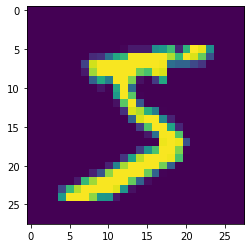

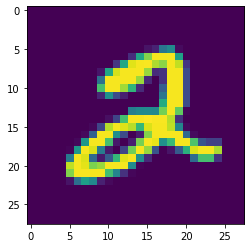

In [71]:
# plot some images
%matplotlib inline
img1 = dataset[0][0]
print("Image1 Size:", tuple(img1.shape))
new_img1 = img1.reshape(28,28)

img2 = dataset[5][0]
new_img2 = img2.reshape(28,28)

plt.figure()
plt.imshow(new_img1)
plt.figure()
plt.imshow(new_img2)

Text(0.5, 1.0, 'distribution of pixels (img2)')

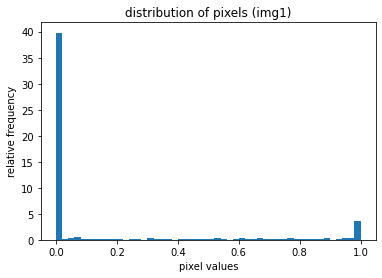

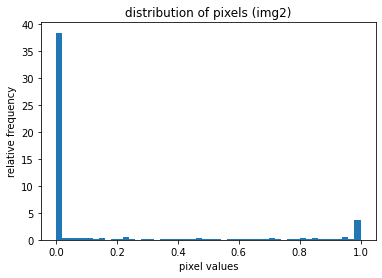

In [72]:
# convert image to numpy array
img_np1 = np.array(new_img1) 
# plot the pixel values
plt.figure()
plt.hist(img_np1.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img1)")

# convert image to numpy array
img_np2 = np.array(new_img2) 
# plot the pixel values
plt.figure()
plt.hist(img_np2.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img2)")


In [73]:
print(np.shape(img_np2.flatten()))

(784,)


In [74]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [75]:
# Create a test and training set
batch_size = 60

to_device = lambda a: a.to(device)

testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [76]:
# Used later to view hidden layer activations
class ActivationTracker(nn.Module):
    '''keeps track of the current activation'''
    def __init__(self):
        super(ActivationTracker, self).__init__()

        # Keep track of [0.15, 0.5, 0.85] percentiles
        self.percents_activation_track = torch.tensor([0.15, 0.50, 0.85]).to(device)
        self.all_percents_activation = []

    def get_all_activations(self):
        return np.array(self.all_percents_activation)
        
    def forward(self, x):
        # track activations of the first node
        percents_activation = torch.quantile(x.detach()[:,0], self.percents_activation_track)
        self.all_percents_activation.append(percents_activation.cpu().detach().numpy())
        return x

In [77]:
#initialize linear layer weights with a gaussian as done in the paper
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight,0, 0.1)
        m.bias.data.fill_(0.01)

In [78]:
# Create a basic network
class VanillaNN(nn.Module):
    def __init__(self): 
        super(VanillaNN, self).__init__()
        self.classifier = nn.Sequential(
            # TODO: what should the input dim be? Hint: size of img data
            nn.Linear(784, 48),  # layer 1
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            ActivationTracker(),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
      return self.classifier

In [79]:
# Using the same structure of the basic network as above, add batch normalization to the input layers
class BatchNormNN(nn.Module):
    def __init__(self): 
        super(BatchNormNN, self).__init__()
        self.classifier = nn.Sequential(
            #TODO: what should the input dim be? Hint: size of img data
            nn.Linear(784,96),   # layer 1
            # TODO: Add batch norm layers before each activation -> nn.BatchNorm1d(size)
            
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Linear(96,48),  # layer 2

            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            
            nn.BatchNorm1d(24),
            ActivationTracker(),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
      return self.classifier

In [80]:
# Used to get the accuracy of a given model
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

Now that we have our data and models defined, let's train both models using the same parameters and compare their loss over time.

In [81]:
# Start here to train the models
model = VanillaNN().to(device)
print(model)
model_bn = BatchNormNN().to(device)
print(model_bn)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

VanillaNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ActivationTracker()
    (4): ReLU()
    (5): Linear(in_features=24, out_features=10, bias=True)
  )
)
BatchNormNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=96, bias=True)
    (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=96, out_features=48, bias=True)
    (4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=24, bias=True)
    (7): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ActivationTracker()
    (9): ReLU()
    (10): Linear(in_features=24, out_features=10, bias=True)
  )
)


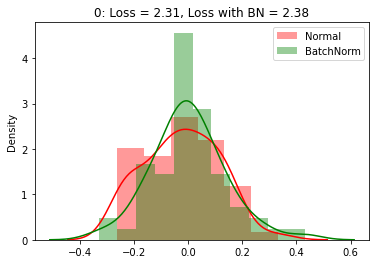

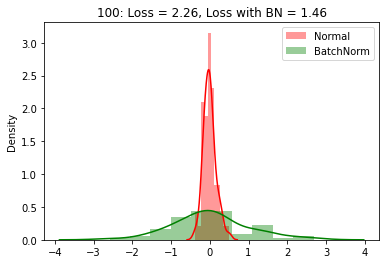

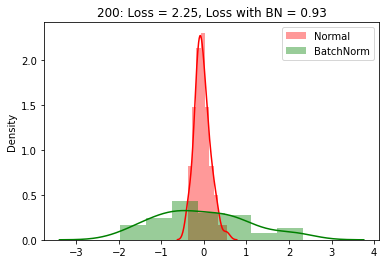

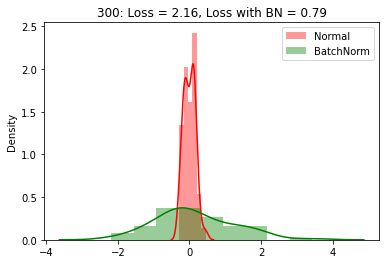

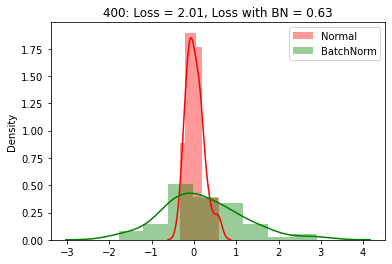

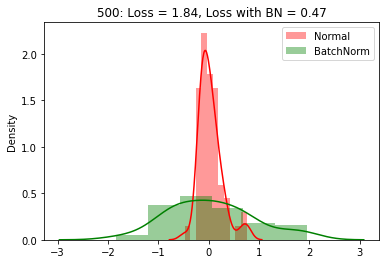

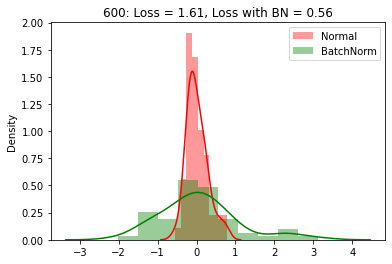

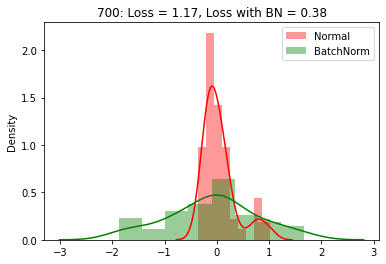

----------------------
0


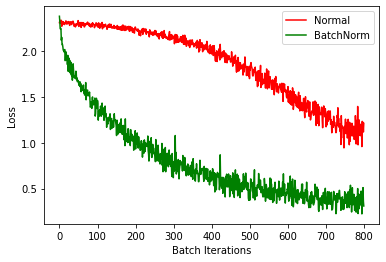

----------------------
1


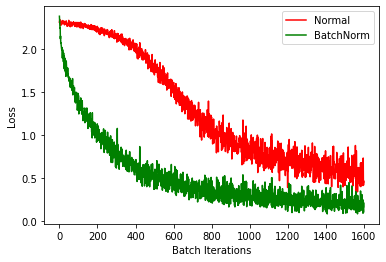

----------------------
2


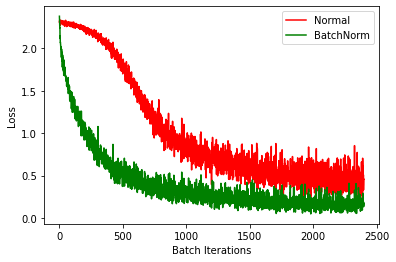

----------------------
3


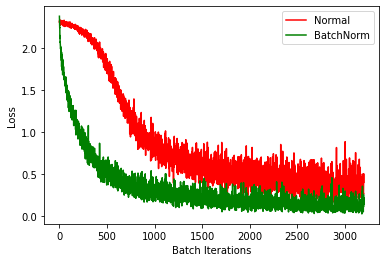

In [82]:
import warnings
warnings.filterwarnings("ignore")

loss_arr = []
loss_bn_arr = []
epochs_stats = []

# TODO: set number of epochs
max_epochs = 4

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        
        

        # training steps for normal model
        # print("train")
        # activations get added here so track iteration
        epochs_stats.append(i+epoch*len(trainloader))
        opt.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs.to(device))
        loss_bn = loss_fn(outputs_bn, labels.to(device))
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        
        if (i % 100 == 0 and epoch == 0):# or (i % 100 == 0 and epoch == 9):
            inputs = inputs.view(inputs.size(0), -1)
            model.eval()
            model_bn.eval()
            
            # plot input layer distributions
            # first linear layer
            a = model.classifier[0](inputs.to(device))
            # inputs to first layer, first node
            a = a[:,0].cpu().detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            # first linear layer, batch layer
            b = model_bn.classifier[0](inputs.to(device))
            b = model_bn.classifier[1](b)
            # inputs to first layer, first node
            b = b[:,0].cpu().detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with BN = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            # plt.savefig('figs/%d.png' % (i))
            plt.pause(0.5)
            model.train()
            model_bn.train()
    
    
    print('----------------------')
    print(epoch)
    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.xlabel("Batch Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# loss of the network with batch normalization reduces much faster than the normal network

There were quite a few visualizations produced while training the models.
We have density plots which show the distribution of the inputs to the first activation for the first node for each model and the loss of the models throughout batch iterations. 

> First Implementation:  
<p >
    <img src="figures/v1-loss.jpg" \>
</p>

**TODO: what are we seeing from the density plots? Think about the pixel value distributions of some of the MNIST data at the beginning, would this influence the output of our plots?**  
> The density plots show that the distribution of density across values in the Batchnorm implementation flattens and spreads out faster than the distrbution of densities for the Normal implementation. While the density distribution for the Normal model approaches the distrbution for the Batchnorm model, it never flattens quite as much. Moreover, the density plots for BN begin to show two peaks in the distribution, at 0 and 1, which is a better representation of the pixel distributions we saw earlier.    

**TODO: compare the loss over time from the vanilla model with the batch norm model. What can we infer from this?**  
> Batchnorm loss approaches convergence much faster, and it also converges to what we can assume is a better result with lower loss. Over time, the stochasticity in the loss of Batchnorm also continues to decrease and does so at a faster rate than the normal approach. This shows that normalization improves the efficiency of training.  

In [53]:
# Get last hidden layer activation (ActivationTracker layer)
# TODO: which layer of the model to use?
baseline_activation = model.get_model()[3].get_all_activations()
bn_activation = model_bn.get_model()[5].get_all_activations()
print(len(baseline_activation), len(epochs_stats) )  # will match len(epochs_stats)

8000 8000


In the paper, they show how the activations from the last layer change during training and compare the Vanilla network to the BatchNorm network (Figure 1(b) and 1(c)).

**TODO: What effect would we expect BatchNorm to have on these last layer activations?**
> We expect that Batchnorm makes the distribution more stable and reduces internal covariate shift. We see this in the image below where the distance between the lines is smaller with BN - this shows that the distribution is at a smaller scale than without BN. The scale for the activations also remains similar throughout training with BN, whereas without BN the scale of the activations changes significantly. The lines are quite close together at the start and then their distance changes rapidly, though stabilizing after a few epochs. This indicates that the weights around these layers are changing more than when using BN.

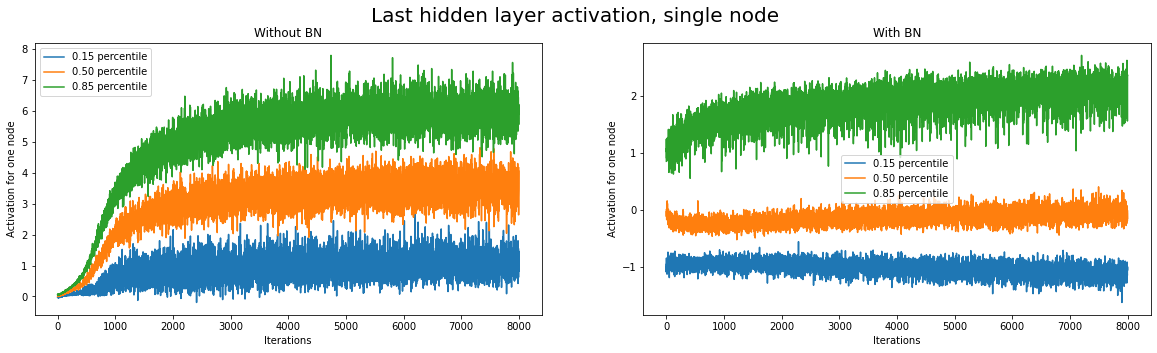

In [54]:
# Display activations
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # -- All iterations
    # Baseline
    ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation for one node')
    
    # BN based
    ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation for one node')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('Last hidden layer activation, single node', fontsize=20)
    plt.show()

**TODO: How do your plots compare to those in the paper? How do they compare to each other? What might explain the differences that you're seeing?**
> For the architecture that is different to the paper, the results for BN are very similar whereas the results without BN are quite different. There is more stable change over time in my results, whereas the results in the paper show a sharp spike early on and then stabilization but divergence in the distrbution shape thereafter. In my results, the shape of the distrbutions for both architectures are spreading less over time. Moreover they seem to be not only more variable in their values, but also they sare more stable showing they are closer to convergence. This is not a good thing though because it indicates the model is not performing quite as well as the model in the paper.  

**TODO: If you make changes to the architecture or training regime, how does this affect the behavior of these last activation values?**
> .  

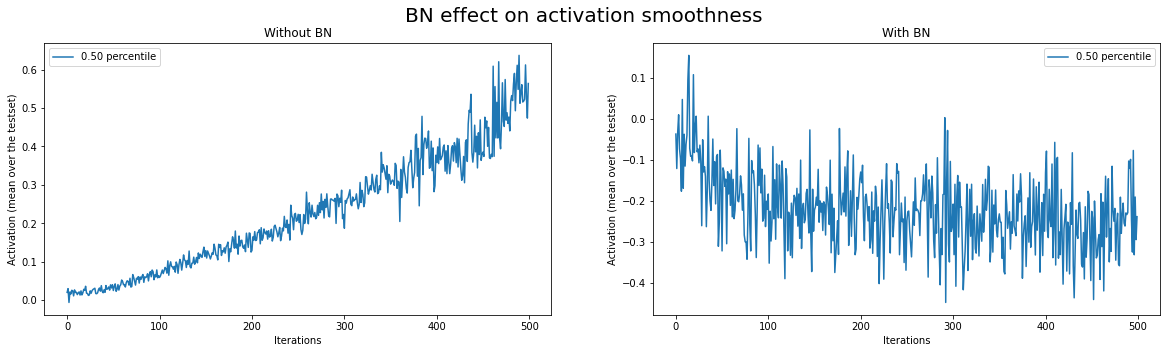

In [55]:
# --Zoom into beginning of above plots to visualize smoothing effect
small_window = 500

if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # Baseline
    ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('BN effect on activation smoothness', fontsize=20)
    plt.show()

In [56]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model, trainloader)
print(f"Epoch {epoch} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model, testloader)
print(f"Epoch {epoch} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn, trainloader)
print(f"Epoch {epoch} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn, testloader)
print(f"Epoch {epoch} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 9 Vanilla Train Accuracy: 92.74%
Epoch 9 Vanilla Test Accuracy: 92.33%

Epoch 9 BN Train Accuracy: 97.80%
Epoch 9 BN Test Accuracy: 96.38%



**TODO: How does the accuracy of the models with and without BatchNorm compare? How does this change when you change the architecture, learning rate, or number of iterations?**
> For my first implementation, the accuracy of the Batchnorm model is better than the Normal model, a difference of roughly 5% in train and 4% in test.  
> * Epoch 9 Vanilla Train Accuracy: 92.74%  
> * Epoch 9 Vanilla Test Accuracy: 92.33%  
> * Epoch 9 BN Train Accuracy: 97.80%  
> * Epoch 9 BN Test Accuracy: 96.38%  
>
> I would think that the difference between accuracies is due to the difference in scale (seen in the activation plots above). With BN, the scale for the loss landscape is smaller and more consistent over time whereas without BN those characteristics change more over time so the BN model is able to converge to a tighter minimum.  
> 
> When I added a layer to the BN model, the variability in loss decreased even within 4 epochs. The diffference is quite noticeable.

